In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
vent = pd.read_csv("vent.csv", sep=";")
vent["time"] = pd.to_datetime(vent["time"], format="%Y-%m-%d %H:%M:%S")

Im folgenden wird ein Modell erarbeitet, welches den Luftfeuchtigkeitsverlauf beim Lüften, nach trainieren einiger Vorfaktoren gut abbilden kann.

Dazu wird mit wenigen wenigen Parametern gestartet: Statt relative Luftfeuchtigkeit und Temperatur wird im ersten Modell die absolute Luftfeuchtigkeit verwendet, wodurch bereits einige Abhänigkeiten wegfallen. Für die anderen Parameter werden Einschränkungen bei den Messpunkten vorgenommen, sodaß in dieser Auswertung bei allen Messungen die Verhältnisse die aktuell noch außen vor gelassen werden sehr ähnlich sind. Das ist nätig, da man nicht wie bei physikalischen Experimenten üblich alle Faktoren bis auf einen konstant halten kann, da bspw. das Wetter nicht beeinflussbar ist.

<AxesSubplot:>

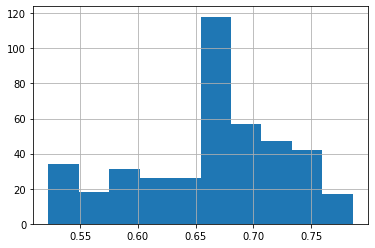

In [2]:
vent["absolute_outside"].hist()

Aus dem Histogramm ergibt sich das die häufigste absolute Außenluftfeuchtigkeit zwischen 0,65 und 0,7 liegt. Deshalb werden die entsprechenden Messreihen verwendet um möglichst wenig Einfluss durch Fluktuationen zu haben, geplotten kommt das hier heraus:

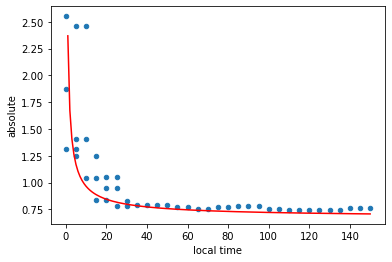

In [3]:
ax = vent[(vent["Id"] == 0) | (vent["Id"] == 2) | (vent["Id"] == 3) | (vent["Id"] == 6)][["local time", "absolute", "absolute_outside"]].plot.scatter(x="local time", y="absolute")

x = np.linspace(1,150,150)
y = 1.7*1/(x**0.76+0.001) +0.67
plt.plot(x,y, 'r')
plt.show()

Beim Versuch eine gute Beschreibung für den Luftfeuchtigkeitsverlauf zu finden entsteht folgende Funktion:

$f(t) = k_0\dfrac{1}{t^{k_1}+k_2} + k_3$

Am simpelsten ist der Faktor $k_2$ dieser ist notwendig, da $\dfrac{1}n$ bei bei $n=0$ undefiniert ist, um also jeglichen nicht negativen Wert für die Funktion einsetzen zu können muss dieser Wert ein klein wenig über 0 sein, welcher Wert wird später durch ein Optimierungsverfahren mithilfe aller Daten bestimmt.

$k_2$ ändert die Steigung der Funktion, denn die Luftfeuchtigkeit fällt nicht exakt mit der Steigung eines normalen $\dfrac{1}n$ ab. Hier ist wahrscheinlich auch die Stellschraube für so etwas wie Fenstergröße, da diese sich auf die Luftaustauschgeschwindigkeit auswirkt.

Was $k_3$ angeht, wirkt es zu erst so, als müsste man diese auch frei optimieren lassen, aber tatsächlich ist es deutlich einfacher. Wenn man den letzten Plot nimmt und noch die Außenluftfeuchtigkeit einzeichnet ergibt sich, folgendes:

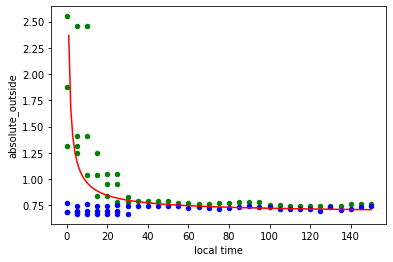

In [4]:
ax = vent[(vent["Id"] == 0) | (vent["Id"] == 2) | (vent["Id"] == 3) | (vent["Id"] == 6)][["local time", "absolute", "absolute_outside"]].plot.scatter(x="local time", y="absolute", color="green")
vent[(vent["Id"] == 0) | (vent["Id"] == 2) | (vent["Id"] == 3) | (vent["Id"] == 6)][["local time", "absolute", "absolute_outside"]].plot.scatter(x="local time", y="absolute_outside", ax=ax, color="blue")

x = np.linspace(1,150,150)
y = 1.7*1/(x**0.76+0.001) +0.67
plt.plot(x,y, 'r')
plt.show()

$k_3$ ist also einfach nur die aktuelle Außenluftfeuchtigkeit.

Was $k_0$ angeht, ist es die Funktion dieses Parameters die Funktion beim ersten Luftfeuchtigkeitspunkt zu starten, dieser ist bekannt und wird als Funktionsparameter übergeben. $k_0$ muss also die Luftfeuchtigkeit zum Zeitpunkt $t=0$ enthalten und es muss das sein was die Funktion zu dem Zeitpunkt ausgibt.

$f(0) = $k_0\dfrac{1}{k_2} + k_3 = h_0$

also. Daraus folgt das $k_0$ im einfachsten Fall $(h_0- k_3)\cdot k_2$ sein muss. Eingesetzt sieht die Funktion also folgendermaßen aus:

$f(t) = (h_0-h_{out})\dfrac{k_2}{t^k_1+ k_2} + h_{out}$

Man sieht auch das für $f(t)\xrightarrow{t\to\infty}h_{out}$ was sehr sinnvoll klingt.

Als nächstes wird die absolute Luftfeuchtigkeit durch Temperatur und relative Luftfeuchtigkeit ersetzt, da die absolute Luftfeuchtigkeit nicht das ist wovon das Wohlbefinden oder das Schimmelwachstum primär abhängt.

Das bedeutet das noch ein zweites Modell benötigt wird welches die Temperatur abbildet, sodass man aus absoluter Luftfeuchtigkeit und Temperatur wieder die relative Luftfeuchtigket bekommen kann

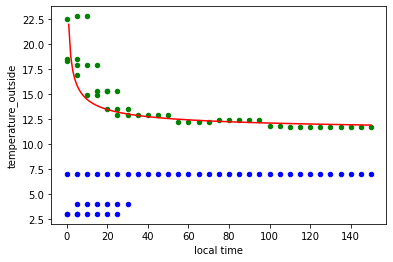

In [5]:
ax = vent[(vent["Id"] == 0) | (vent["Id"] == 2) | (vent["Id"] == 3) | (vent["Id"] == 6)].plot.scatter(x="local time", y="temperature_bathroom_middle", color="green")
vent[(vent["Id"] == 0) | (vent["Id"] == 2) | (vent["Id"] == 3) | (vent["Id"] == 6)].plot.scatter(x="local time", y="temperature_outside", ax=ax, color="blue")

x = np.linspace(1,150,150)
y = 11*1/(x**0.5+0.001) +11
plt.plot(x,y, 'r')
plt.show()

Man sieht das der Verlauf dem der absoluten Luftfeuchtigkeit sehr ähnlich sieht, abgesehen davon das es deutlich langsamer ist und deshalb die Außentemperatur im Plot nicht erreicht. Da es in diesem Modell nicht darum geht wie die Temperatur nach außen abfällt wird hier nicht nach einer besseren Funktion gesucht welche irgendwann die Außentemperatur erreicht, denn die Daten zeigen das dies erst lange nach der für die Luftfeuchtigkeit relevanten Zeit passiert. Es wird also das Modell der Luftfeuchtigkeit mit eigenen Parametern genommen und noch ein Parameter an die Außentemperatur gehängt:

$f_T(t) = (h_0-(h_{out}\cdot k_0))\dfrac{k_2}{t^k_1+ k_2} + (h_{out}\cdot k_0)$

Die beiden Modelle kann man dann mit der bekannten Formel zur relativen Luftfeuchtigkeit zusammenführen.

Als nächstes wird betrachtet wie sich die Fenstergröße auf Luftfeuchtigkeit und Temperatur auswirkt

<AxesSubplot:xlabel='local time', ylabel='absolute'>

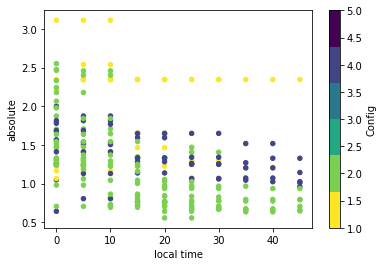

In [6]:
fig, ax = plt.subplots()
vent[vent["local time"] <50].plot.scatter(x="local time", y="absolute", c="Config", colormap=plt.cm.get_cmap('viridis_r', 6), ax=ax)

Die zahlen von Config 1-4 sind ein Code um zu beschreiben wie die Fenster geöffnet sind, muss in der Praxis natürlich durch die Maße der Fensteröffnung ersetzt werden, damit es kontinuirliche Daten sind, die auch einen wirklichen Sinn haben. Hier sieht man relativ klar das je mehr Fensterfläche offen ist, desto schneller sinkt die Luftfeuchtigkeit. (2 bedeutet beide Fenster weit offen; 4 beide Fenster geklappt und 1 ein Fenster weit offen).

Bei der Temperatur sieht es folgendermaßen aus:

<AxesSubplot:xlabel='local time', ylabel='temperature_bathroom_middle'>

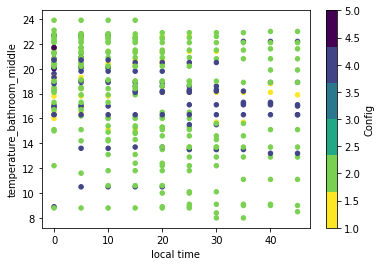

In [7]:
fig, ax = plt.subplots()
vent[vent["local time"] <50].plot.scatter(x="local time", y="temperature_bathroom_middle", c="Config", colormap=plt.cm.get_cmap('viridis_r', 6), ax=ax)

Es ist eine starke Streuung aller Werte zu sehen es ist also nicht stark davon abhängig. Man sollte also immer möglichst viel Fensterfläche offen haben um schnell viel Luftfeuchtigkeit im Verhältnis zur Temperatur zu verlieren. Da sich die Fensterfläche auf die Steigung auswirkt ändert sich das Teilmodell der Luftfeuchtigkeit folgendermaßen:

$f_h(t) = (h_0-h_{out})\dfrac{k_2}{t^{k_1 F_{größe}}+ k_2} + h_{out}$

Was die Raumgröße angeht ist es relativ klar das je mehr Platz ist desto weniger fällt steigende absolute Luftfeuchtigkeit erstmal ins Gewicht da es sich verteilt. Die Außenluftfeuchtigkeit ändert sich von einem Duschen bspw. auch nicht. Gleichzeitig muss wenn die Luftfeuchtigkeit erstmal über einem kritischen Wert ist mehr Luftfeuchtigkeit entweichen um die Luftfeuchtigkeit des ganzen Raums wieder zu senken. Es handelt sich also um einen Faktor der die Steigung dämpft. Dies ist leider nicht an den Daten zu belegen, da die Räume die zum testen benutzt wurden eine relativ ähnliche Größe haben und vorallem die Fenstergrößen sehr unterschiedlich sind, was einen Vergleich schwierig macht.  Das Teilmodell erweitert sich also folgendermaßen:

$f_h(t) = (h_0-h_{out})\dfrac{k_2}{t^{\dfrac{k_1 F_{größe}}{k_3 R_{größe}}}+ k_2} + h_{out}$
Dasselbe gilt natürlich auch für die Temperatur:

$f_T(t) = (h_0-(h_{out}\cdot k_0))\dfrac{k_2}{t^{\dfrac{k_1}{k_3R_{größe}}}+ k_2} + (h_{out}\cdot k_0)$

Wenn man die Teilmodelle jetzt zusammenfügt ergibt sich:
aktuelle Temperatur zur maximalen absoluten Luftfeuchtigkeit:
$e_s = C_2 exp\left( \dfrac{\dfrac{-L}{R_w}}{f_T(t)+273,15}\right)$

Und dann schließlich die Umrechnung in die relative Luftfeuchtigkeit:
$RH = \dfrac{f_h(t)}{e_s}\cdot 100$